# Forward Selection for a GPR model 

Suppose we are given the following model 
$$
y_i \approx m x_i + \sum_{k=1}^K a_k \sin(\omega_k x_i) + \sum_{i=1}^K b_k \cos(\omega_k x_i)
$$
We can write
$$
y \approx A(\omega, K) \theta
$$
where the design matrix $A(\omega, K)$ is determined solely by the frequency parameters $\omega$ and the remaining parameters can be organized as a vector $\theta = (m, a_{1:K}, b_{1:K})$. 

In [1242]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy as sc
import pandas as pd
import seaborn as sns
from IPython.html.widgets import *

### Data Generation

In [1243]:
# This data is generated for K=4,N=50,m=0.2. It is distorted with a noise as well. You may try to obtain a similar plot or
# generate a different one.
N=50; K=4; m = np.array([0.2]).reshape(1,1)

x = (np.random.rand(N)*2-1).reshape(N,1)
# Select a and b coefficients
#a = (np.random.rand(K)*2-1).reshape(K,1)
#b = (np.random.rand(K)*2-1).reshape(K,1)
a = np.array([1,2,3,4]).reshape(K,1)
b = np.array([1,2,3,4]).reshape(K,1)

om_true = np.array([0,np.pi/2,np.pi,np.pi*3/2]).reshape(K,1)
noise = np.random.normal(0, 0.5, N).reshape(N,1)

# Create design matrix
def make_design_matrix(x, om):
    # Fill this method
    A = np.hstack((np.hstack((x,np.sin(np.dot(x,om.T)))),np.cos(np.dot(x,om.T))))
    return A

A = make_design_matrix(x.reshape(N,1), om_true)

# Create parameter vector
theta = np.vstack((np.vstack((m,a)),b))

#Generate the output
y = np.dot(A,theta) + noise



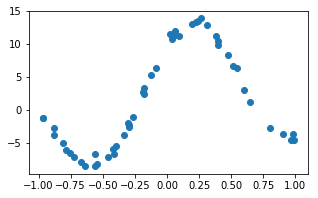

In [1244]:
fig = plt.figure(figsize=(5,3))
plt.scatter(x,y)

### Selection Method

First we select each x value one by one and compute prediction outputs together with the variance for each remaining input. We take the average of absolute variances of remaining inputs. 

The one minimizing the average variance over the remaining points is selected as the next point.

In [1252]:
%matplotlib notebook
# Calculates Covariance Matrix with exponential kernel
# Returns the matrix in 2d array
def calculateCovarianceMatrix(x, length, coef, heat):
    if type(x) != 'numpy.ndarray':
        x = np.array(x).reshape(len(x),1)
    K = np.zeros((len(x), len(x)))
    for i in range(len(x)):
        xi = np.full((len(x),1), x[i])
        K[i] = np.power(coef,2)*np.exp(-np.multiply(np.linalg.norm(xi-x,axis=1),np.linalg.norm(xi-x,axis=1))/(2*length*length))
    if heat==1:
        fig = plt.figure(figsize=(7,5))
        ax = fig.add_subplot(111)
        ax.set_title("Covariance Matrix")
        sns.heatmap(K)
    return K

# Fits a Gaussian Process Model with the training data
# Returns Inv of Noisy Covariance Matrix in 2d array
def fit(x, length, coef, noise, heat):
    K = calculateCovarianceMatrix(x, length, coef, heat)
    NoisyK = K + np.power(noise,2)*np.identity(len(K))
    NoisyK_inv = np.linalg.pinv(NoisyK)
    return NoisyK, NoisyK_inv

# Predicts output and std deviation
# Returns input, true and predicted output and deviation
def predict(X_test, y_test, X_train, y_train, Ky_inv, length, coef, noise):
    X_train_vect = np.full((len(X_test),len(X_train)), X_train.T)
    corrVec = np.power(coef,2)*np.exp(-np.multiply(X_train_vect-X_test,X_train_vect-X_test)/(2*length*length))
    correlationWithItself = np.power(coef,2)
    posterior_mean = np.zeros((len(X_test),1))
    for i in range(len(corrVec)):
        cv = corrVec[i].reshape(1,len(X_train))
        posterior_mean[i] = (cv.dot(Ky_inv)).dot(y_train)
    posterior_cov = np.zeros((len(X_test),1))
    for i in range(len(corrVec)):
        cv = corrVec[i].reshape(1,len(X_train))
        posterior_cov[i] = correlationWithItself - (cv.dot(Ky_inv)).dot(cv.T)
    minus = (posterior_mean - 3 * np.sqrt(np.abs(posterior_cov)))
    plus = (posterior_mean + 3 * np.sqrt(np.abs(posterior_cov)))
    data = np.hstack((np.hstack((np.hstack((np.hstack((np.hstack((X_test, y_test)),posterior_mean)),posterior_cov)),plus)),minus))
    return data

def iterate(ax1,x,y,MAX_BATCH):
    ax1.cla()
    ax2 = fig2.add_subplot(122)
    ax2.cla()
    X_selected = []
    y_selected = []
    x_temp = x; y_temp = y
    
    for b in range(MAX_BATCH):
        preData = np.zeros((len(x_temp),len(x_temp)-1,7))
        avgVar = np.zeros((len(x_temp),1))
        for i in range(len(x_temp)):
            X_test = np.array(np.delete(x_temp, i, 0))
            y_test = np.array(np.delete(y_temp, i, 0))
            if b!=0:
                X_train = np.vstack((np.array(X_selected[:b]), np.array(x_temp[i])))
                y_train = np.vstack((np.array(y_selected[:b]), np.array(y_temp[i])))
            else:
                X_train = np.array(x_temp[i])
                y_train = np.array(y_temp[i])
            Ky, Ky_inv = fit(X_train, length, coef, noise, 0)
            i_ = np.full((len(preData[i]),1),np.where(x==x_temp[i])[0])
            preData[i] = np.hstack((i_,predict(X_test, y_test, X_train, y_train, Ky_inv, length, coef, noise)))
            avgVar[i] = np.mean(np.abs(preData[i][:,4]))
        preDataBatch.append(preData)
        avgVarBatch.append(avgVar)
        X_selected.append(np.array(x_temp[np.argmin(avgVar)]))
        y_selected.append(np.array(y_temp[np.argmin(avgVar)]))
        x_temp = np.delete(x_temp, np.argmin(avgVar), 0)
        y_temp = np.delete(y_temp, np.argmin(avgVar), 0)
    
    #Gather selected points over all batches
    idx=np.zeros((len(X_selected),1)).astype(np.int)
    for b in range(MAX_BATCH):
        idx[b] = np.where(x==X_selected[b])[0]
    
    selected.append(list(np.hstack((np.array(X_selected),np.array(y_selected)))))
    
    #Plot the selected points 
    #Selection is based on the avg variance over the remaining points
    ax1.set_ylabel("y")
    ax1.set_xlabel("x")
    ax1.set_ylim(-10,15)
    ax1.set_xlim(-1.01,1.01)
    ax1.scatter(X_selected,y_selected, marker='^', color='purple', label='actively selected')
    ax1.scatter(np.delete(x, idx,0), np.delete(y, idx,0), marker='x', color='blue', label='true output')
    
    if MAX_BATCH!=0:
        lastPrediction = preDataBatch[-1]
        #Last selected point location is found and corresponding mean and variance data is got 
        #for the rest of the unselected points 
        lastPrediction = lastPrediction[np.where(lastPrediction[:,:,0]==idx[-1])[0][0]]
        #predicted output array is taken to be plotted.
        predictedOutput = lastPrediction[:,3]
        ax1.scatter(np.delete(x, idx,0),predictedOutput, marker='+', color='darkorange', label='predicted output')
        #Variance is plotted
        df = pd.DataFrame(lastPrediction).sort_values(by=[1],ascending=True).reset_index(drop=True)
        var_plus = df[5]
        var_minus = df[6]
        ax1.plot(df[1],var_plus, color='orange', label='min_var')
        ax1.plot(df[1],var_minus, color='orange', label='plus_var')
    ax1.legend() 
    
length = 0.2; coef = 1; noise = 0.1
preDataBatch = []
avgVarBatch = []
selected=[]
def drawVariance(eventx, eventy):
    ax2 = fig2.add_subplot(122)
    ax2.cla()
    
    #Finding the index of the data which is clicked from the plot
    xy_ = np.hstack((x,y)).reshape(len(x),2)
    eventx = np.array(eventx).reshape(1,1)
    eventy = np.array(eventy).reshape(1,1)
    eventxy = np.hstack((eventx,eventy)).reshape(1,2)
    eventxy_ = np.full((len(x),2), eventxy)
    diff = np.linalg.norm(xy_-eventxy_, axis=1)
    idx = np.argmin(diff)
    
    ax2.set_ylim(-10,15)
    ax2.set_xlim(-1.01,1.01)
    #ax2.txt("Remaining variance is ")
    
    x_plot = np.delete(x,idx,0)    
    y_plot = np.delete(y,idx,0)
    if len(selected[-1])!=0:
        for i in np.array(selected[-1])[:,0]:
            x_plot = np.delete(x_plot, np.where(x==i)[0],0)
            y_plot = np.delete(y_plot, np.where(x==i)[0],0)
        X_selected = np.array(selected[-1])[:,0].reshape(len(np.array(selected[-1])[:,0]),1)
        y_selected = np.array(selected[-1])[:,1].reshape(len(np.array(selected[-1])[:,0]),1)
    else:
        X_selected = np.array([])
        y_selected = np.array([])
    #Observations plotted
    ax2.scatter(x_plot, y_plot, marker='x', color='blue', label='true output')
    #Manuel selection plotted
    ax2.scatter(x[idx],y[idx], marker='o', color='green', label='selected')
    ax2.legend()
    
    #Prev active selections plotted
    
    ax2.scatter(X_selected,y_selected, marker='^', color='purple', label='actively selected')
    #x values which are used as training
    if len(selected[-1])!=0:
        X_train = np.vstack((x[idx].reshape(len(x[idx]),1),X_selected))
        y_train = np.vstack((y[idx].reshape(len(y[idx]),1),y_selected))
    else:
        X_train = x[idx].reshape(len(x[idx]),1)
        y_train = y[idx].reshape(len(y[idx]),1)
    
    Ky,Ky_inv = fit(X_train, length, coef, noise, 0)
    preData = predict(x_plot, y_plot, X_train, y_train, Ky_inv, length, coef, noise)
    avgVar = np.mean(np.abs(preData[:,3]))
    ax2.set_title("avg var "+str(avgVar))
    
    df = pd.DataFrame(preData).sort_values(by=[0],ascending=True).reset_index(drop=True)
    ax2.plot(df[0],df[4], color='orange', label='variance')
    ax2.plot(df[0],df[5], color='orange', label='variance')
    
def onclick(event):
    eventx = event.xdata
    eventy = event.ydata
    drawVariance(eventx, eventy)
    fig2.canvas.draw()

<IPython.core.display.Javascript object>


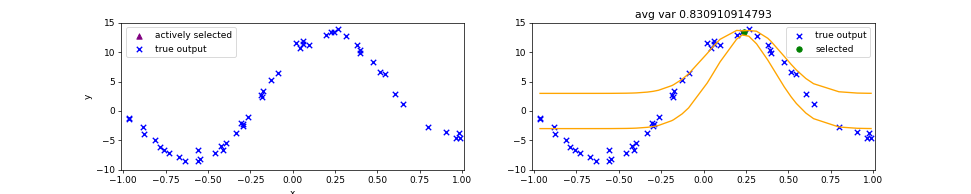

interactive(children=(IntSlider(value=0, description='MAX_BATCH', max=50), Output()), _dom_classes=('widget-interact',))

In [1253]:
fig2 = plt.figure(figsize=(15,3))
ax1 = fig2.add_subplot(121)
selected = []
interact(iterate, ax1=fixed(ax1), x=fixed(x),y=fixed(y),MAX_BATCH=widgets.IntSlider(min=0,max=50,step=1,value=0))#(1,25,1))
cid = fig2.canvas.mpl_connect('button_press_event',onclick)